<a href="https://colab.research.google.com/github/pixelm/notebooks/blob/master/Detecting_graduate_admissions_bias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Is there bias in the graudate admisison process?

The goal is detect whether there is inherent bias in the admissions process based on this data. This is public data available on Kaggle. The dataset contains several parameters which are considered important during the application for Masters Programs. The parameters included are GRE Scores,  TOEFL Scores,  University Rating, Statement of Purpose and Letter of Recommendation Strength, Undergraduate GPA, Research Experience and Chance of Admit. 

The assumpiton is that the predictability of the chance of admit variable is inversely correlated to human bias. The outliers found by the model may signal bias. 

In [0]:
from google.cloud import bigquery
from google.colab import auth 

In [0]:
auth.authenticate_user()

In [0]:
import pandas as pd
from pandas import DataFrame as df 
import numpy as np  


In [0]:
def query_to_df(query):
  df = pd.read_gbq(query, project_id='waylon-230305', dialect='standard')
  return df 
  


In [0]:
training_data_table = """
select * from cdct_test.expero_applicant_train 

"""

In [0]:
training_data_raw = query_to_df(training_data_table)
training_data_raw.columns = ['GRE', 'TOEFL', 'uni_rating', 'SOP', 'LOR', 'CGPA', 'has_research', 'p_admit', 'id']
training_data_raw.head()


,GRE,TOEFL,uni_rating,SOP,LOR,CGPA,has_research,p_admit,id
0,290,104,4,2.0,2.5,7.46,0,0.45,43
1,293,97,2,2.0,4.0,7.80,1,0.64,410
2,295,93,1,2.0,2.0,7.20,0,0.46,436
3,297,101,3,2.0,4.0,7.67,1,0.57,314
4,298,97,2,2.0,3.0,7.21,0,0.45,352


### **Data exploration**

In [0]:
import seaborn
import seaborn.apionly as sns
from  matplotlib import pyplot as plt

/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)
/usr/local/lib/python3.6/dist-packages/seaborn/apionly.py:9: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [0]:
sns.set_style("darkgrid")

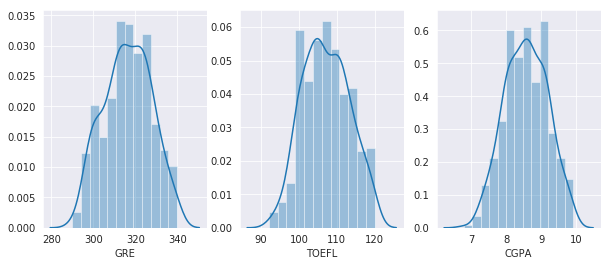

In [0]:
fig, ax =plt.subplots(1,3, figsize=(10,4))
sns.distplot(training_data_raw['GRE'], ax=ax[0]) 
sns.distplot(training_data_raw['TOEFL'], ax=ax[1]) 
sns.distplot(training_data_raw['CGPA'], ax=ax[2]) 


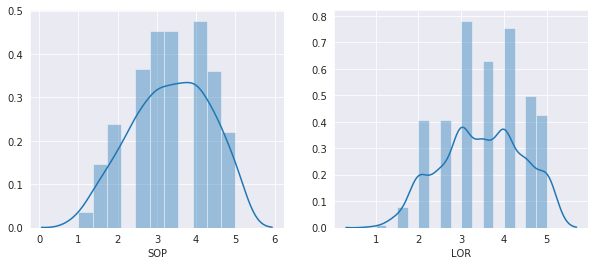

In [0]:
fig, ax =plt.subplots(1,2, figsize=(10,4))
sns.distplot(training_data_raw['SOP'], ax=ax[0]) 
sns.distplot(training_data_raw['LOR'], ax=ax[1]) 


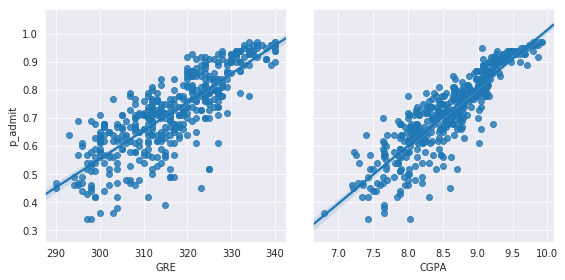

In [0]:
g = sns.PairGrid(training_data_raw, x_vars=['GRE','CGPA'], y_vars='p_admit', height=4)
g.map(sns.regplot)

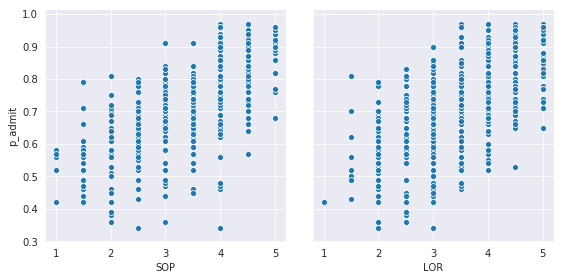

In [0]:
sns.pairplot(training_data_raw, x_vars=['SOP','LOR'], y_vars='p_admit', height=4)


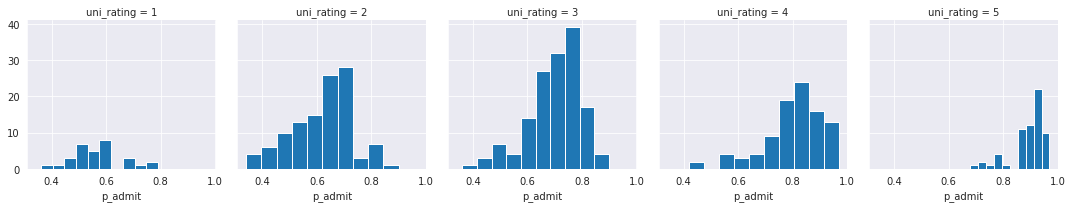

In [0]:
#looking at categorical variables 
g = sns.FacetGrid(training_data_raw, col="uni_rating")
g.map(plt.hist, "p_admit")

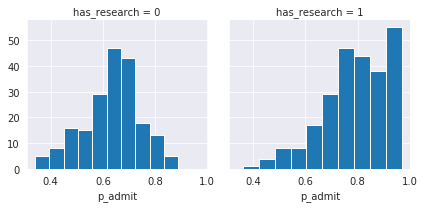

In [0]:
g = sns.FacetGrid(training_data_raw, col="has_research")
g.map(plt.hist, "p_admit")

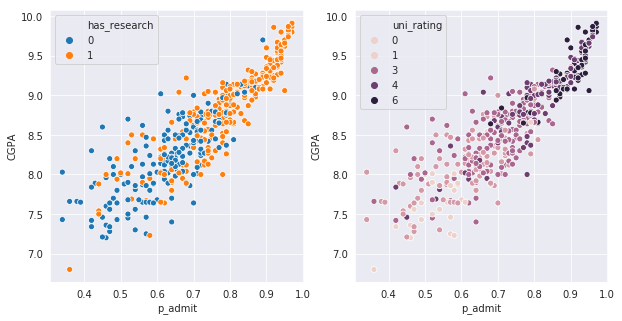

In [0]:
fg, ax = plt.subplots(1, 2, figsize = (10, 5))
sns.scatterplot(x="p_admit", y="CGPA", hue="has_research", data=training_data_raw, ax=ax[0])
sns.scatterplot(x="p_admit", y="CGPA", hue="uni_rating", data=training_data_raw, ax=ax[1])

### **Linear Model**

In [0]:
#from sklearn.feature_selection import SelectKBest
#from sklearn.feature_selection import f_regression
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics 
from sklearn.neural_network import MLPRegressor
import statsmodels.api as sm
from sklearn import preprocessing

In [0]:
X = training_data_raw[['GRE', 'uni_rating', 'SOP', 'LOR', 'CGPA', 'has_research']]
y = training_data_raw[['p_admit']]


In [0]:
# normalize X 

normalize_X = preprocessing.MinMaxScaler(feature_range=(0, 1))
float_array = X.values.astype(float)
scaled_array = normalize_X.fit_transform(float_array)
X = df(scaled_array)
X.columns = ['GRE', 'uni_rating', 'SOP', 'LOR', 'CGPA', 'has_research']



In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [0]:
#lm = linear_model.LinearRegression()
#nn = MLPRegressor(hidden_layer_sizes=(15,),   solver='lbfgs')
ols = sm.OLS(y_train, X_train) # picked sm because sklearn doesnt have standard error 
ols_results = ols.fit()

Text(0.5, 1.0, 'Standard Err')

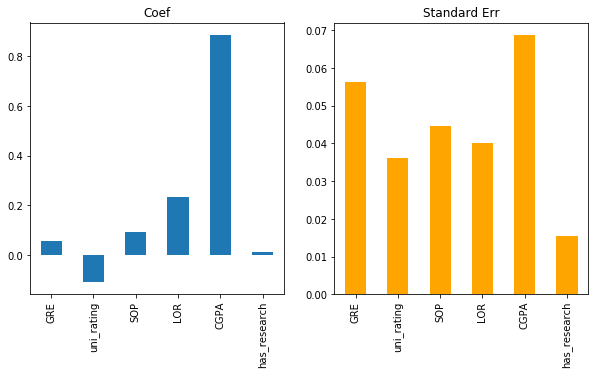

In [0]:
fg, ax = plt.subplots(1, 2, figsize = (10, 5))
ols_results.params.plot.bar(ax=ax[0]).set_title('Coef') 
ols_results.bse.plot.bar(ax=ax[1], color='orange').set_title('Standard Err') 
#plot coefficients 

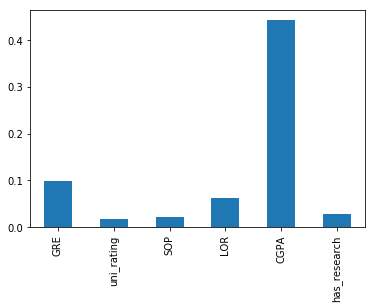

In [0]:
# check sklearn lm  to see if you get similar results 
lm = linear_model.LinearRegression()
lm.fit(X_train, y_train)
lm_coef = df(lm.coef_)
lm_coef.columns = X.columns
lm_coef.transpose().plot.bar(legend=False)


In [0]:
ols_prediction = ols_results.predict(X_test)

In [0]:
y_test_series = df(y_test)
pred_series = df(ols_prediction)
y_test_pred_concat = pd.concat([y_test_series, pred_series], axis=1)
y_test_pred = y_test_pred_concat.dropna()
y_test_pred= y_test_pred.sort_index()
y_test_pred.columns = ['y_test', 'predicted']

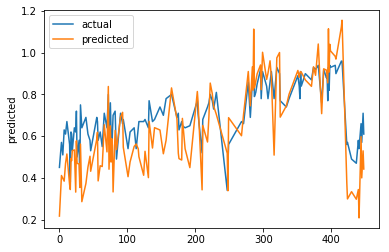

In [0]:
sns.lineplot(y_test_pred.index, y_test_pred.y_test, label="actual")
sns.lineplot(y_test_pred.index, y_test_pred.predicted, label="predicted")

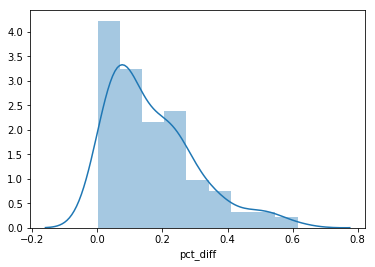

In [0]:
# diff between actual and predicted 
y_test_pred['diff'] = y_test_pred['y_test'] - y_test_pred['predicted']
y_test_pred["pct_diff"] = abs(y_test_pred['diff'] / y_test_pred['y_test'])
sns.distplot(y_test_pred['pct_diff'])

In [0]:
ols_results.summary()
ols_results.bse

GRE             0.056278
uni_rating      0.036185
SOP             0.044668
LOR             0.040243
CGPA            0.068632
has_research    0.015491
dtype: float64

### Above results suggests a high concentration of results are less than .40 error which signals towards predictability of the model. 

other things you can do to improve the model 
--- add a pipe for feature selection  
--- compare results with nn regression 
--- try fixed effects (see below)

In [0]:
training_data_raw_v2 = training_data_raw
#training_data_raw_v2['has_research'] = training_data_raw['has_research'].astype('category')
training_data_raw_v2['uni_rating'] = training_data_raw['uni_rating'].astype('category')
training_data_raw_v2 = pd.get_dummies(training_data_raw_v2)
training_data_raw_v2.head()

In [0]:
#X = training_data_raw_v2[['SOP', 'CGPA', 'uni_rating_1', 'uni_rating_2','uni_rating_3', 'uni_rating_4', 'uni_rating_5','has_research_0', 'has_research_1']]
X = training_data_raw_v2[['SOP', 'CGPA','has_research_1', 'uni_rating_3', 'uni_rating_4', 'uni_rating_5']]
y = training_data_raw_v2[['p_admit']]

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [0]:
ols = sm.OLS(y_train, X_train) # picked sm because sklearn doesnt have standard error 
ols_results = ols.fit()

In [0]:
fg, ax = plt.subplots(1, 2, figsize = (10, 5))
ols_results.params.plot.bar(ax=ax[0]) # coefficients
ols_results.bse.plot.bar(ax=ax[1], color='orange')

In [0]:
ols_prediction = ols_results.predict(X_test)

In [0]:
y_test_series = df(y_test)
pred_series = df(ols_prediction)
y_test_pred_concat = pd.concat([y_test_series, pred_series], axis=1)
y_test_pred = y_test_pred_concat.dropna()
y_test_pred= y_test_pred.sort_index()
y_test_pred.columns = ['y_test', 'predicted']

In [0]:
sns.lineplot(y_test_pred.index, y_test_pred.y_test, label="actual")
sns.lineplot(y_test_pred.index, y_test_pred.predicted, label="predicted")

Colab to GBQ 

In [0]:
import pandas_gbq

In [0]:
# push y test and y pred back to gbq  
pandas_gbq.to_gbq(y_test_pred, 'cdct_test.y_test_pred', project_id='waylon-230305')